In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


D:\Anaconda\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt 
import time

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_dataset = ImageDataGenerator(rescale=1./255)
test_dataset = ImageDataGenerator(rescale=1./255)
validation_dataset = ImageDataGenerator(rescale=1./255)


#BATCH_SIZE = 32
#IMG_SIZE = (160, 160)
#train_dir='Database/Train/'
#validation_dir='Database/Valid/'
#train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            #shuffle=True,
                                                            #batch_size=BATCH_SIZE,
                                                            #image_size=IMG_SIZE)
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                # shuffle=True,
                                                                # batch_size=BATCH_SIZE,
                                                                 #image_size=IMG_SIZE)
#import tensorflow as tf
#AUTOTUNE = tf.data.AUTOTUNE

#train_dataset= train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_datagen = test_datagen.prefetch(buffer_size=AUTOTUNE)
 
batchsize = 10
train_generator=train_dataset.flow_from_directory('Acrima/Train/', 
                                                  target_size=(224, 224), 
                                                  batch_size=batchsize, 
                                                  class_mode='categorical')
 
validation_generator = validation_dataset.flow_from_directory('Acrima/Valid',
        target_size=(224, 224),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)
test_generator = test_dataset.flow_from_directory('Acrima/Test/',
       target_size=(224, 224),
       batch_size=batchsize,
       class_mode='categorical',
       shuffle=False)

Found 360 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


# Model Creation
VGG Net: VGG network has simplest structure with 3 x 3 filter in each convolutional layer. There are two variant available VGG-16 and VGG1-9. In the image above VGG network is presneted.
Transfer Learning: The VGGNet pre-trained on ImageNet and Inception module for transfer learning, and trained the newly formed neural networks using new datasets. The approach combines the advantages of the VGGNet and Inception module.

In [4]:
#DENSENET121
base_model1=keras.applications.DenseNet121(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)

#DenseNet169
base_model2=keras.applications.DenseNet169(
    include_top=True, weights="imagenet", input_tensor=None, 
    input_shape=None, pooling=None,classes=1000,
    #classifier_activation='softmax'
)


#VGG19
base_model3=keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#MobileNet
base_model4=tf.keras.applications.MobileNetV2(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

#ResNet50 
base_model5 = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax')

#Inception V3
base_model6=tf.keras.applications.InceptionV3(
    include_top=True, weights="imagenet", input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation="softmax",
)




## setting all layers as non-trainable

In [5]:
for layer in base_model1.layers:
    layer.trainable=False
for layer in base_model2.layers:
    layer.trainable=False
for layer in base_model3.layers:
    layer.trainable=False
for layer in base_model4.layers:
    layer.trainable=False
for layer in base_model5.layers:
    layer.trainable=False
for layer in base_model6.layers:
    layer.trainable=False

## Defining custom activation function
As per the paper, custom activation function Swish is used in place of Relu in the model.

In [6]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

## Defining convolution batch normalization function with Swish activation

In [7]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1)):   
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides)(x)
    x = Lambda(swish)(x)
    x = BatchNormalization(axis=3)(x)  
    return x

## Defining Inception Block:
Inception Modules are used in Convolutional Neural Networks to allow for more efficient computation and deeper Networks through a dimensionality reduction with stacked 1×1 convolutions. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues.

In [8]:
def Inception(x,nb_filter):  
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
  
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1))  
  
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1))  
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(3,3), padding='same',strides=(1,1))
  
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)  
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1))  
  
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)    
    return x

## Adding new layers in model architechture
Global Average Pooling
Fully connected layers are replaced by a global pooling layer to conduct the dimension reduction of feature maps.

In [9]:
#DenseNet121
x = base_model1.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_1 = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model1.input, outputs=predictions_1)

In [10]:
#DenseNet169
x = base_model2.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_2 = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions_2)

In [11]:
#VGG-19
x = base_model3.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_3 = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=predictions_3)

In [12]:
#MobileNet V2
x = base_model4.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_4 = Dense(2, activation='softmax')(x)
model4 = Model(inputs=base_model4.input, outputs=predictions_4)

In [13]:
#ResNet 50
x = base_model5.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_5 = Dense(2, activation='softmax')(x)
model5 = Model(inputs=base_model5.input, outputs=predictions_5)

In [14]:
#Inception V3
x = base_model6.layers[-6].output


x = Conv2d_BN(x,512,(3,3),strides=(1,1),padding='same')  
x = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x) 

x = Inception(x,512)  
x = Inception(x,512)  

x = GlobalAveragePooling2D()(x)
predictions_6 = Dense(2, activation='softmax')(x)
model6 = Model(inputs=base_model6.input, outputs=predictions_6)

In [15]:

model1.summary()
model2.summary()
model3.summary()
model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 conv2d_96 (Conv2D)             (None, 7, 7, 512)    262656      ['max_pooling2d_4[0][0]']        
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 512)    2359808     ['batch_normalization_98[0][0]'] 
                                                                                                  
 lambda_2 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_96[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 7, 7, 512)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_96 (BatchN  (None, 7, 7, 512)   2048        ['lambda_2[0][0]']               
 ormalizat

 lambda_10 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_104[0][0]']             
                                                                                                  
 lambda_13 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_107[0][0]']             
                                                                                                  
 lambda_14 (Lambda)             (None, 7, 7, 512)    0           ['conv2d_108[0][0]']             
                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['lambda_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 512)   2048        ['lambda_10[0][0]']              
 Normaliza

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_concat (Concatena  (None, 56, 56, 128)  0          ['conv2_block1_concat[0][0]',    
 te)                                                              'conv2_block2_2_conv[0][0]']    
                                                                                                  
 conv2_blo

 conv2_block6_concat (Concatena  (None, 56, 56, 256)  0          ['conv2_block5_concat[0][0]',    
 te)                                                              'conv2_block6_2_conv[0][0]']    
                                                                                                  
 pool2_bn (BatchNormalization)  (None, 56, 56, 256)  1024        ['conv2_block6_concat[0][0]']    
                                                                                                  
 pool2_relu (Activation)        (None, 56, 56, 256)  0           ['pool2_bn[0][0]']               
                                                                                                  
 pool2_conv (Conv2D)            (None, 56, 56, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 28, 28, 128)  0           ['pool2_conv[0][0]']             
          

                                                                                                  
 conv3_block4_concat (Concatena  (None, 28, 28, 256)  0          ['conv3_block3_concat[0][0]',    
 te)                                                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, 28, 28, 256)  1024       ['conv3_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, 28, 28, 256)  0          ['conv3_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block9_0_relu (Activatio  (None, 28, 28, 384)  0          ['conv3_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, 28, 28, 128)  49152       ['conv3_block9_0_relu[0][0]']    
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block9_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block1_0_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 128)  32768       ['conv4_block1_0_relu[0][0]']    
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_concat (Concatena  (None, 14, 14, 416)  0          ['conv4_block4_concat[0][0]',    
 te)                                                              'conv4_block5_2_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block9_concat (Concatena  (None, 14, 14, 544)  0          ['conv4_block8_concat[0][0]',    
 te)                                                              'conv4_block9_2_conv[0][0]']    
                                                                                                  
 conv4_block10_0_bn (BatchNorma  (None, 14, 14, 544)  2176       ['conv4_block9_concat[0][0]']    
 lization)                                                                                        
                                                                                                  
 conv4_block10_0_relu (Activati  (None, 14, 14, 544)  0          ['conv4_block10_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 128)  69632       ['conv4_block10_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 128)  86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block18_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block18_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block18_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block18_1_relu[0][0]']   
                                                                                                  
 conv4_block18_concat (Concaten  (None, 14, 14, 832)  0          ['conv4_block17_concat[0][0]',   
 ate)                                                             'conv4_block18_2_conv[0][0]']   
                                                                                                  
 conv4_block19_0_bn (BatchNorma  (None, 14, 14, 832)  3328       ['conv4_block18_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block23_0_bn (BatchNorma  (None, 14, 14, 960)  3840       ['conv4_block22_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_0_relu (Activati  (None, 14, 14, 960)  0          ['conv4_block23_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 128)  122880      ['conv4_block23_0_relu[0][0]']   
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block23_1_conv[0][0]']   
 lization)

 conv4_block27_1_conv (Conv2D)  (None, 14, 14, 128)  139264      ['conv4_block27_0_relu[0][0]']   
                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block31_1_relu[0][0]']   
                                                                                                  
 conv4_block31_concat (Concaten  (None, 14, 14, 1248  0          ['conv4_block30_concat[0][0]',   
 ate)                           )                                 'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, 14, 14, 1248  4992       ['conv4_block31_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block32_0_relu (Activati  (None, 14, 14, 1248  0          ['conv4_block32_0_bn[0][0]']     
 on)      

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_concat (Concatena  (None, 7, 7, 736)   0           ['conv5_block2_concat[0][0]',    
 te)                                                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, 7, 7, 736)   2944        ['conv5_block3_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_block8_0_bn (BatchNormal  (None, 7, 7, 864)   3456        ['conv5_block7_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block8_0_relu (Activatio  (None, 7, 7, 864)   0           ['conv5_block8_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block8_1_conv (Conv2D)   (None, 7, 7, 128)    110592      ['conv5_block8_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block12_1_conv (Conv2D)  (None, 7, 7, 128)    126976      ['conv5_block12_0_relu[0][0]']   
                                                                                                  
 conv5_block12_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block12_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block12_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block12_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block12_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block12_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 7, 7, 1152)  0           ['conv5_block15_concat[0][0]',   
 ate)                                                             'conv5_block16_2_conv[0][0]']   
                                                                                                  
 conv5_block17_0_bn (BatchNorma  (None, 7, 7, 1152)  4608        ['conv5_block16_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block21_0_bn (BatchNorma  (None, 7, 7, 1280)  5120        ['conv5_block20_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block21_0_relu (Activati  (None, 7, 7, 1280)  0           ['conv5_block21_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block21_1_conv (Conv2D)  (None, 7, 7, 128)    163840      ['conv5_block21_0_relu[0][0]']   
                                                                                                  
 conv5_block21_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block21_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block25_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block25_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block25_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block25_1_relu[0][0]']   
                                                                                                  
 conv5_block25_concat (Concaten  (None, 7, 7, 1440)  0           ['conv5_block24_concat[0][0]',   
 ate)     

 conv5_block29_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block29_1_relu[0][0]']   
                                                                                                  
 conv5_block29_concat (Concaten  (None, 7, 7, 1568)  0           ['conv5_block28_concat[0][0]',   
 ate)                                                             'conv5_block29_2_conv[0][0]']   
                                                                                                  
 conv5_block30_0_bn (BatchNorma  (None, 7, 7, 1568)  6272        ['conv5_block29_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block30_0_relu (Activati  (None, 7, 7, 1568)  0           ['conv5_block30_0_bn[0][0]']     
 on)                                                                                              
          

 batch_normalization_111 (Batch  (None, 7, 7, 512)   2048        ['lambda_17[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_114 (Batch  (None, 7, 7, 512)   2048        ['lambda_20[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 7, 7, 512)   0           ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_110 (Conv2D)            (None, 7, 7, 512)    262656      ['max_pooling2d_7[0][0]']        
                                                                                                  
 conv2d_11

 batch_normalization_119 (Batch  (None, 7, 7, 512)   2048        ['lambda_25[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_122 (Batch  (None, 7, 7, 512)   2048        ['lambda_28[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_123 (Batch  (None, 7, 7, 512)   2048        ['lambda_29[0][0]']              
 Normalization)                                                                                   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Compiling the Model 

In [16]:
def comp():
    learning_rate=0.0001
    decay=1e-6
    momentum=0.8
    nesterov=True
    sgd_optimizer= SGD(lr = learning_rate, decay = decay, momentum = momentum, nesterov = nesterov)
    models=['DenseNet169','DenseNet121','VGG-19','MobileNet','ResNet50','Inception']
    
    for i in models:
        if i=='DenseNet121':
            model1.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        elif i=='DenseNet169':
            model2.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='VGG-19':
            model3.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='MobileNet':
            model4.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        if i=='ResNet50':
            model5.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])
        else:
            model6.compile(loss='categorical_crossentropy',optimizer=sgd_optimizer,metrics=['accuracy','mse'])

        
if __name__ == "__main__":
    comp()

D:\Anaconda\envs\tf-gpu\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training the Models

### 1.DenseNet-121

In [17]:
#DenseNet121
import time
epochs =50
batch_size = 10

start = time.time()
history_1 = model1.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 27s 353ms/step - loss: 0.6405 - accuracy: 0.6444 - mse: 0.2226 - val_loss: 0.7088 - val_accuracy: 0.2366 - val_mse: 0.2578
Epoch 2/50
36/36 [==============================] - 7s 206ms/step - loss: 0.4915 - accuracy: 0.7389 - mse: 0.1631 - val_loss: 0.7439 - val_accuracy: 0.2366 - val_mse: 0.2753
Epoch 3/50
36/36 [==============================] - 7s 205ms/step - loss: 0.4449 - accuracy: 0.8000 - mse: 0.1455 - val_loss: 0.7973 - val_accuracy: 0.2366 - val_mse: 0.3016
Epoch 4/50
36/36 [==============================] - 7s 206ms/step - loss: 0.4420 - accuracy: 0.7861 - mse: 0.1445 - val_loss: 0.8425 - val_accuracy: 0.2366 - val_mse: 0.3232
Epoch 5/50
36/36 [==============================] - 7s 206ms/step - loss: 0.3776 - accuracy: 0.8472 - mse: 0.1168 - val_loss: 0.9141 - val_accuracy: 0.2366 - val_mse: 0.3564
Epoch 6/50
36/36 [==============================] - 7s 207ms/step - loss: 0.3414 - accuracy: 0.8750 - mse: 0.1031 - val_loss: 1.0

Epoch 48/50
36/36 [==============================] - 8s 210ms/step - loss: 0.1094 - accuracy: 0.9861 - mse: 0.0234 - val_loss: 0.3738 - val_accuracy: 0.8172 - val_mse: 0.1261
Epoch 49/50
36/36 [==============================] - 8s 213ms/step - loss: 0.0809 - accuracy: 0.9944 - mse: 0.0135 - val_loss: 0.3632 - val_accuracy: 0.8065 - val_mse: 0.1217
Epoch 50/50
36/36 [==============================] - 7s 205ms/step - loss: 0.0926 - accuracy: 0.9917 - mse: 0.0179 - val_loss: 0.3662 - val_accuracy: 0.8172 - val_mse: 0.1226
Execution Time :  390.48376393318176


In [18]:
model1.save_weights('SavedModels/Acrima/D121.h5')

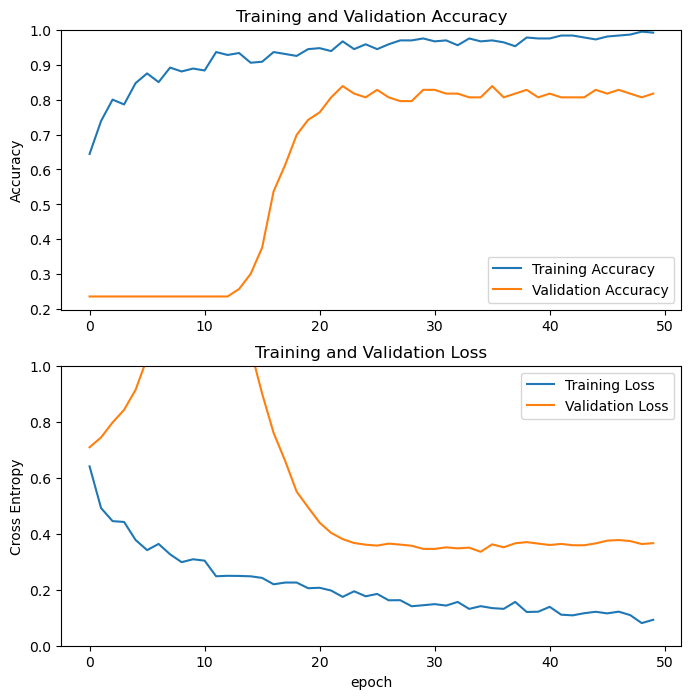

In [20]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
start=time.time()
test_output_1= model1.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model1.metrics_names)
print(test_output_1)
print("testing time : "+ str(end-start))

22/22 [==============================] - 2s 81ms/step - loss: 0.5121 - accuracy: 0.7758 - mse: 0.1596
['loss', 'accuracy', 'mse']
[0.5120837688446045, 0.7757847309112549, 0.15964916348457336]
testing time : 2.1967902183532715


In [22]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model1.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 4s 117ms/step
Confusion Matrix
[[155  45]
 [  5  18]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.97      0.78      0.86       200
      Normal       0.29      0.78      0.42        23

    accuracy                           0.78       223
   macro avg       0.63      0.78      0.64       223
weighted avg       0.90      0.78      0.82       223



In [23]:
import itertools

Text(0.5, 23.52222222222222, 'Predicted label')

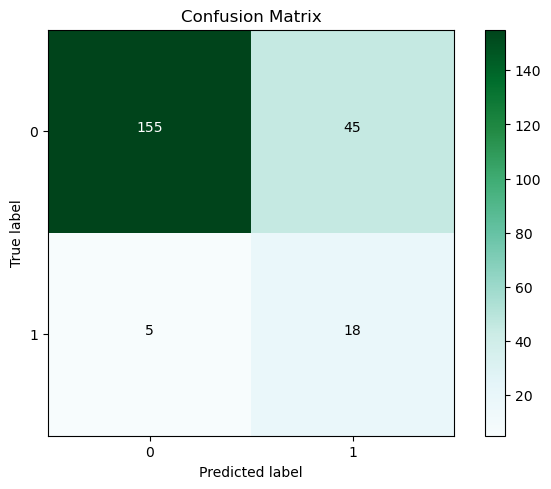

In [24]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### DenseNet-169

In [25]:
#DenseNet169
import time
epochs =50
batch_size = 10

start = time.time()
history_2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 22s 348ms/step - loss: 0.6210 - accuracy: 0.6722 - mse: 0.2143 - val_loss: 0.7240 - val_accuracy: 0.2366 - val_mse: 0.2654
Epoch 2/50
36/36 [==============================] - 9s 240ms/step - loss: 0.5259 - accuracy: 0.7444 - mse: 0.1732 - val_loss: 0.7331 - val_accuracy: 0.2366 - val_mse: 0.2699
Epoch 3/50
36/36 [==============================] - 9s 239ms/step - loss: 0.4898 - accuracy: 0.8028 - mse: 0.1585 - val_loss: 0.7409 - val_accuracy: 0.2366 - val_mse: 0.2738
Epoch 4/50
36/36 [==============================] - 8s 237ms/step - loss: 0.4333 - accuracy: 0.8167 - mse: 0.1364 - val_loss: 0.7541 - val_accuracy: 0.2366 - val_mse: 0.2804
Epoch 5/50
36/36 [==============================] - 8s 235ms/step - loss: 0.4140 - accuracy: 0.8278 - mse: 0.1301 - val_loss: 0.7551 - val_accuracy: 0.2366 - val_mse: 0.2808
Epoch 6/50
36/36 [==============================] - 9s 238ms/step - loss: 0.3811 - accuracy: 0.8528 - mse: 0.1180 - val_loss: 0.7

Epoch 48/50
36/36 [==============================] - 8s 235ms/step - loss: 0.1356 - accuracy: 0.9694 - mse: 0.0319 - val_loss: 0.3188 - val_accuracy: 0.8710 - val_mse: 0.0980
Epoch 49/50
36/36 [==============================] - 9s 237ms/step - loss: 0.1217 - accuracy: 0.9778 - mse: 0.0265 - val_loss: 0.3172 - val_accuracy: 0.8710 - val_mse: 0.0976
Epoch 50/50
36/36 [==============================] - 8s 235ms/step - loss: 0.1299 - accuracy: 0.9750 - mse: 0.0294 - val_loss: 0.3297 - val_accuracy: 0.8602 - val_mse: 0.1029
Execution Time :  438.4785306453705


In [26]:

model2.save_weights('SavedModels/Acrima/D169.h5')

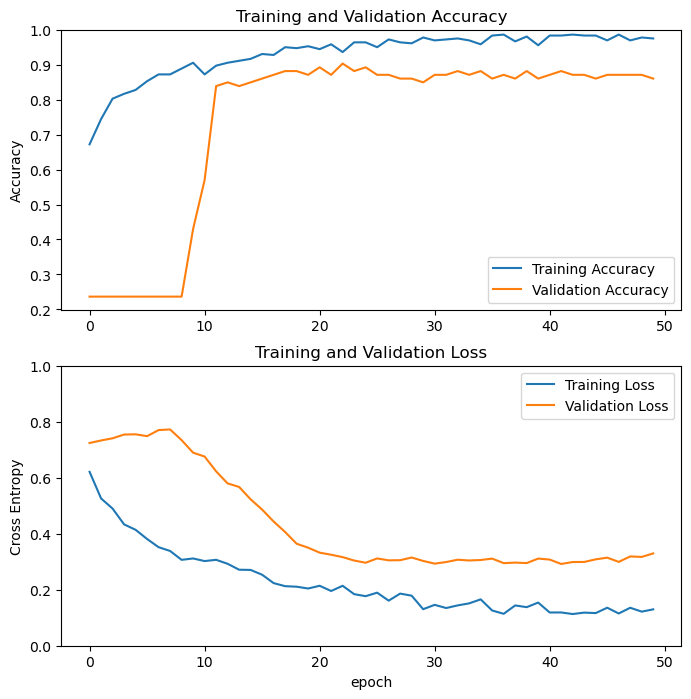

In [27]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
start=time.time()
test_output_2= model2.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model2.metrics_names)
print(test_output_2)
print("testing time : "+ str(end-start))

22/22 [==============================] - 3s 137ms/step - loss: 0.5282 - accuracy: 0.7534 - mse: 0.1622
['loss', 'accuracy', 'mse']
[0.5282312035560608, 0.7533632516860962, 0.16223213076591492]
testing time : 3.406362771987915


In [30]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model2.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 5s 136ms/step
Confusion Matrix
[[146  54]
 [  1  22]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.99      0.73      0.84       200
      Normal       0.29      0.96      0.44        23

    accuracy                           0.75       223
   macro avg       0.64      0.84      0.64       223
weighted avg       0.92      0.75      0.80       223



Text(0.5, 23.52222222222222, 'Predicted label')

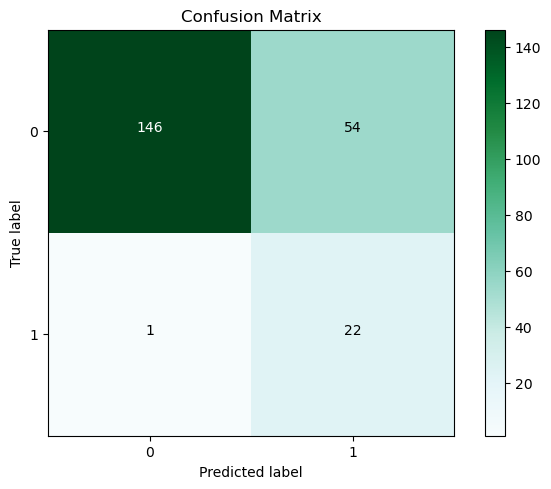

In [31]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 3. VGG-19

In [17]:
#Vgg-19
import time
epochs =50
batch_size = 10

start = time.time()
history_3 = model3.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 33s 601ms/step - loss: 0.5944 - accuracy: 0.7028 - mse: 0.2033 - val_loss: 0.7225 - val_accuracy: 0.2366 - val_mse: 0.2647
Epoch 2/50
36/36 [==============================] - 19s 519ms/step - loss: 0.4531 - accuracy: 0.8083 - mse: 0.1432 - val_loss: 0.7681 - val_accuracy: 0.2366 - val_mse: 0.2873
Epoch 3/50
36/36 [==============================] - 18s 515ms/step - loss: 0.3924 - accuracy: 0.8417 - mse: 0.1212 - val_loss: 0.8475 - val_accuracy: 0.2366 - val_mse: 0.3256
Epoch 4/50
36/36 [==============================] - 18s 513ms/step - loss: 0.3633 - accuracy: 0.8583 - mse: 0.1105 - val_loss: 0.9343 - val_accuracy: 0.2366 - val_mse: 0.3654
Epoch 5/50
36/36 [==============================] - 19s 524ms/step - loss: 0.3514 - accuracy: 0.8694 - mse: 0.1073 - val_loss: 1.0352 - val_accuracy: 0.2366 - val_mse: 0.4084
Epoch 6/50
36/36 [==============================] - 18s 513ms/step - loss: 0.3428 - accuracy: 0.8444 - mse: 0.1048 - val_loss

In [18]:
model3.save_weights('SavedModels/Acrima/VGG19.h5')

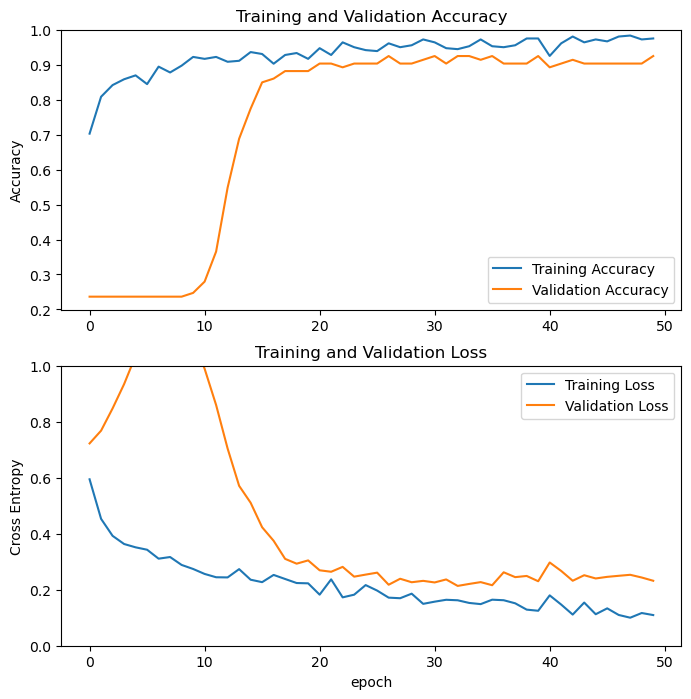

In [19]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
start=time.time()
test_output_3= model3.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model3.metrics_names)
print(test_output_3)
print("testing time : "+ str(end-start))

22/22 [==============================] - 4s 165ms/step - loss: 0.2454 - accuracy: 0.8879 - mse: 0.0726
['loss', 'accuracy', 'mse']
[0.2454274445772171, 0.8878923654556274, 0.07261836528778076]
testing time : 4.007648944854736


In [21]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model3.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 7s 298ms/step
Confusion Matrix
[[177  23]
 [  2  21]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.99      0.89      0.93       200
      Normal       0.48      0.91      0.63        23

    accuracy                           0.89       223
   macro avg       0.73      0.90      0.78       223
weighted avg       0.94      0.89      0.90       223



Text(0.5, 23.52222222222222, 'Predicted label')

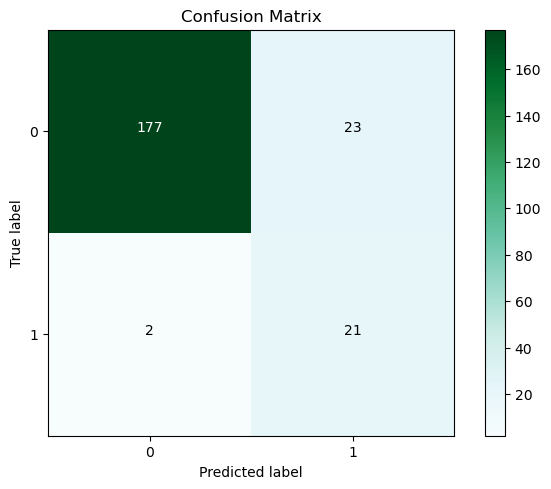

In [23]:
import itertools
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 4. MobileNet V2

In [24]:
#MobileNet 
import time
epochs =50
batch_size = 10

start = time.time()
history_4 = model4.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 11s 195ms/step - loss: 0.6439 - accuracy: 0.6083 - mse: 0.2268 - val_loss: 0.8232 - val_accuracy: 0.3118 - val_mse: 0.3120
Epoch 2/50
36/36 [==============================] - 5s 146ms/step - loss: 0.4989 - accuracy: 0.7806 - mse: 0.1625 - val_loss: 0.7022 - val_accuracy: 0.4946 - val_mse: 0.2550
Epoch 3/50
36/36 [==============================] - 5s 147ms/step - loss: 0.4108 - accuracy: 0.8361 - mse: 0.1264 - val_loss: 0.5945 - val_accuracy: 0.6989 - val_mse: 0.2039
Epoch 4/50
36/36 [==============================] - 5s 146ms/step - loss: 0.3747 - accuracy: 0.8444 - mse: 0.1135 - val_loss: 0.5156 - val_accuracy: 0.7849 - val_mse: 0.1688
Epoch 5/50
36/36 [==============================] - 5s 146ms/step - loss: 0.3366 - accuracy: 0.8778 - mse: 0.0990 - val_loss: 0.4329 - val_accuracy: 0.8495 - val_mse: 0.1344
Epoch 6/50
36/36 [==============================] - 5s 146ms/step - loss: 0.2954 - accuracy: 0.8944 - mse: 0.0836 - val_loss: 0.3

Epoch 48/50
36/36 [==============================] - 5s 146ms/step - loss: 0.0710 - accuracy: 0.9917 - mse: 0.0133 - val_loss: 0.1851 - val_accuracy: 0.8817 - val_mse: 0.0655
Epoch 49/50
36/36 [==============================] - 5s 146ms/step - loss: 0.0772 - accuracy: 0.9889 - mse: 0.0162 - val_loss: 0.1852 - val_accuracy: 0.8817 - val_mse: 0.0651
Epoch 50/50
36/36 [==============================] - 5s 145ms/step - loss: 0.0575 - accuracy: 0.9944 - mse: 0.0095 - val_loss: 0.1866 - val_accuracy: 0.8817 - val_mse: 0.0657
Execution Time :  270.83236598968506


In [25]:
model4.save_weights('SavedModels/Acrima/MobileNet.h5')

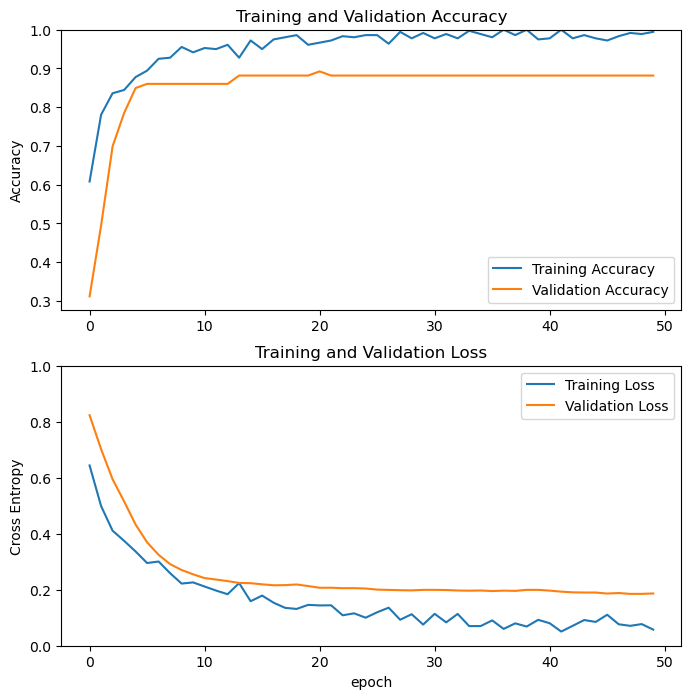

In [26]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
start=time.time()
test_output_4= model4.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model4.metrics_names)
print(test_output_4)
print("testing time : "+ str(end-start))

22/22 [==============================] - 2s 70ms/step - loss: 0.1722 - accuracy: 0.9372 - mse: 0.0481
['loss', 'accuracy', 'mse']
[0.17222927510738373, 0.9372197389602661, 0.04813459515571594]
testing time : 1.966176986694336


In [28]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model4.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 3s 85ms/step
Confusion Matrix
[[189  11]
 [  3  20]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.98      0.94      0.96       200
      Normal       0.65      0.87      0.74        23

    accuracy                           0.94       223
   macro avg       0.81      0.91      0.85       223
weighted avg       0.95      0.94      0.94       223



Text(0.5, 23.52222222222222, 'Predicted label')

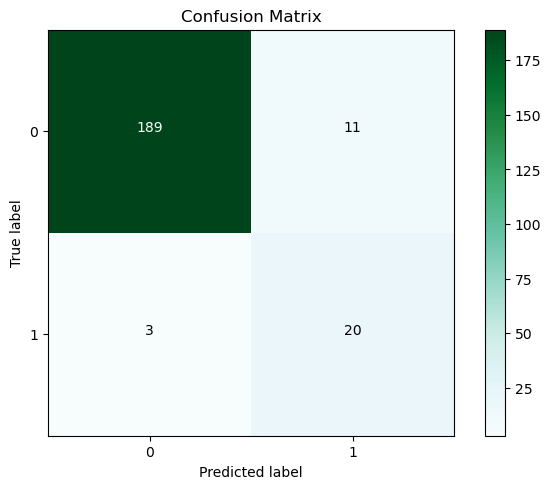

In [29]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ResNet50

In [30]:
#ResNet 50
import time
epochs =50
batch_size = 10

start = time.time()
history_5 = model5.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 15s 311ms/step - loss: 0.6835 - accuracy: 0.6333 - mse: 0.2452 - val_loss: 0.6105 - val_accuracy: 0.7634 - val_mse: 0.2091
Epoch 2/50
36/36 [==============================] - 10s 271ms/step - loss: 0.6559 - accuracy: 0.7389 - mse: 0.2315 - val_loss: 0.5563 - val_accuracy: 0.7634 - val_mse: 0.1843
Epoch 3/50
36/36 [==============================] - 10s 270ms/step - loss: 0.6351 - accuracy: 0.7639 - mse: 0.2212 - val_loss: 0.5499 - val_accuracy: 0.7634 - val_mse: 0.1816
Epoch 4/50
36/36 [==============================] - 10s 270ms/step - loss: 0.6151 - accuracy: 0.8083 - mse: 0.2115 - val_loss: 0.5833 - val_accuracy: 0.7634 - val_mse: 0.1907
Epoch 5/50
36/36 [==============================] - 10s 271ms/step - loss: 0.5960 - accuracy: 0.7861 - mse: 0.2023 - val_loss: 0.6429 - val_accuracy: 0.7634 - val_mse: 0.2023
Epoch 6/50
36/36 [==============================] - 10s 271ms/step - loss: 0.5744 - accuracy: 0.8194 - mse: 0.1922 - val_loss

In [31]:
model5.save_weights('SavedModels/Acrima/ResNet.h5')

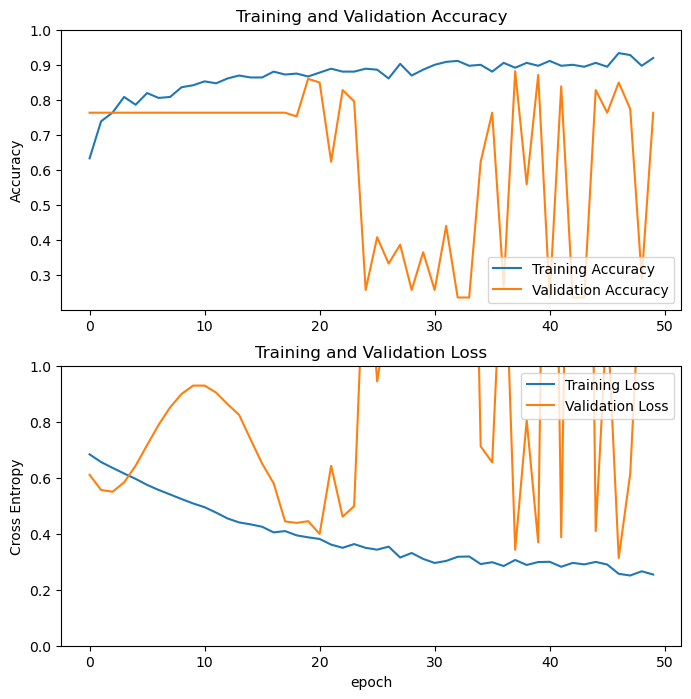

In [32]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
start=time.time()
test_output_5= model5.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model5.metrics_names)
print(test_output_5)
print("testing time : "+ str(end-start))

22/22 [==============================] - 3s 110ms/step - loss: 0.5034 - accuracy: 0.8969 - mse: 0.1009
['loss', 'accuracy', 'mse']
[0.5034489035606384, 0.8968609571456909, 0.10088735073804855]
testing time : 2.8990769386291504


In [34]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model5.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 4s 155ms/step
Confusion Matrix
[[200   0]
 [ 23   0]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.90      1.00      0.95       200
      Normal       0.00      0.00      0.00        23

    accuracy                           0.90       223
   macro avg       0.45      0.50      0.47       223
weighted avg       0.80      0.90      0.85       223



D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 23.52222222222222, 'Predicted label')

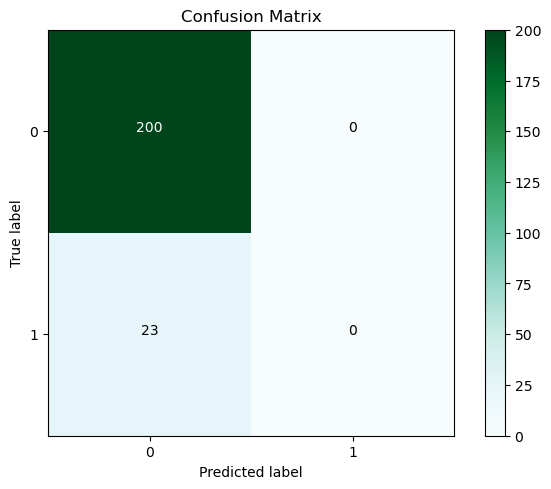

In [35]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6. Inception V3

In [36]:
#Inception V3
import time
epochs =50
batch_size = 10

start = time.time()
history_6 = model6.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epochs, batch_size =batch_size,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
end = time.time()
print("Execution Time : ", (end - start))

Epoch 1/50
36/36 [==============================] - 16s 271ms/step - loss: 0.7225 - accuracy: 0.5528 - mse: 0.2602 - val_loss: 0.7405 - val_accuracy: 0.4086 - val_mse: 0.2738
Epoch 2/50
36/36 [==============================] - 7s 192ms/step - loss: 0.5296 - accuracy: 0.7500 - mse: 0.1764 - val_loss: 0.6870 - val_accuracy: 0.4624 - val_mse: 0.2481
Epoch 3/50
36/36 [==============================] - 7s 192ms/step - loss: 0.4300 - accuracy: 0.8028 - mse: 0.1368 - val_loss: 0.6288 - val_accuracy: 0.5699 - val_mse: 0.2206
Epoch 4/50
36/36 [==============================] - 7s 189ms/step - loss: 0.3939 - accuracy: 0.8167 - mse: 0.1221 - val_loss: 0.5829 - val_accuracy: 0.6344 - val_mse: 0.1999
Epoch 5/50
36/36 [==============================] - 7s 191ms/step - loss: 0.3432 - accuracy: 0.8694 - mse: 0.1023 - val_loss: 0.5069 - val_accuracy: 0.7527 - val_mse: 0.1665
Epoch 6/50
36/36 [==============================] - 7s 191ms/step - loss: 0.2978 - accuracy: 0.9222 - mse: 0.0837 - val_loss: 0.4

Epoch 48/50
36/36 [==============================] - 7s 185ms/step - loss: 0.0801 - accuracy: 0.9750 - mse: 0.0187 - val_loss: 0.2043 - val_accuracy: 0.9247 - val_mse: 0.0610
Epoch 49/50
36/36 [==============================] - 7s 185ms/step - loss: 0.0680 - accuracy: 0.9972 - mse: 0.0119 - val_loss: 0.2030 - val_accuracy: 0.9247 - val_mse: 0.0598
Epoch 50/50
36/36 [==============================] - 7s 185ms/step - loss: 0.0509 - accuracy: 0.9972 - mse: 0.0080 - val_loss: 0.1968 - val_accuracy: 0.9247 - val_mse: 0.0571
Execution Time :  345.4274673461914


In [37]:
model6.save_weights('SavedModels/Acrima/Inception.h5')

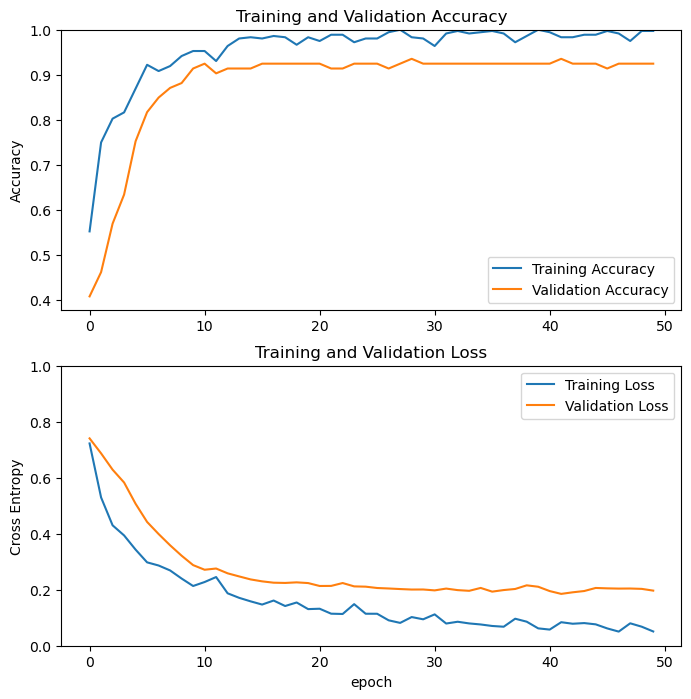

In [38]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
start=time.time()
test_output_6= model6.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
end=time.time()
print(model6.metrics_names)
print(test_output_6)
print("testing time : "+ str(end-start))

22/22 [==============================] - 3s 102ms/step - loss: 0.5114 - accuracy: 0.7803 - mse: 0.1497
['loss', 'accuracy', 'mse']
[0.5113653540611267, 0.7802690863609314, 0.14974196255207062]
testing time : 2.854823350906372


In [40]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Y_pred = model1.predict_generator(validation_generator, 171 // batch_size+1)
Y_pred=model6.predict(test_generator,test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf=confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('Classification Report')
target_names = ['Gluacoma', 'Normal']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

23/23 [==============================] - 4s 108ms/step
Confusion Matrix
[[155  45]
 [  4  19]]
Classification Report
              precision    recall  f1-score   support

    Gluacoma       0.97      0.78      0.86       200
      Normal       0.30      0.83      0.44        23

    accuracy                           0.78       223
   macro avg       0.64      0.80      0.65       223
weighted avg       0.90      0.78      0.82       223



Text(0.5, 23.52222222222222, 'Predicted label')

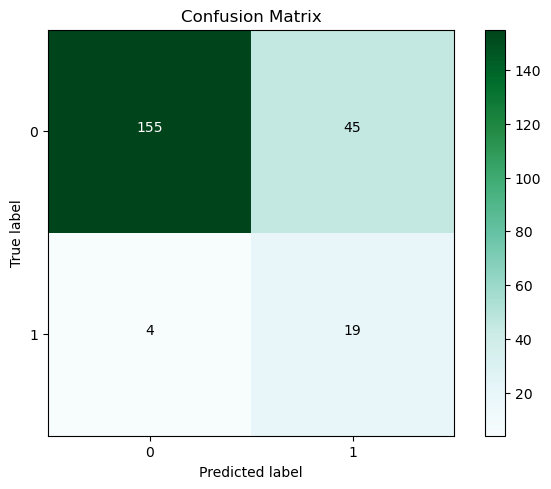

In [41]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')